In [1]:
# Fish Position Tracking
# Script by Dhruv Zocchi PhD, Janelia Research Campus
import cv2
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askdirectory
from pathlib import Path
import numpy as np
from utils import *
from tqdm import tqdm
import time
import threading
import queue
import h5py


In [5]:
def get_average_brightness(image, position, text_size):
    """
    Calculate the average brightness of a region in the image.

    Parameters:
    - image: The image to calculate brightness on.
    - position: A tuple (x, y) specifying the position of the top-left corner of the region.
    - text_size: A tuple (width, height) specifying the size of the region.

    Returns:
    - The average brightness of the region.
    """
    x, y = position
    width, height = text_size
    region = image[y:y+height, x:x+width]
    return np.mean(region)

def add_text_to_image(image, text, position):
    """
    Add text to an image at the specified position, adjusting the color based on the background brightness.

    Parameters:
    - image: The image to add text to.
    - text: The text string to add.
    - position: A tuple (x, y) specifying the position of the text.

    Returns:
    - The image with the text added.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    avg_brightness = get_average_brightness(image, position, text_size)

    # Choose text color based on brightness
    if avg_brightness > 127:
        color = (0, 0, 0)  # Black color text
    else:
        color = (255, 255, 255)  # White color text

    cv2.putText(image, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
    return image

def combine_images(images, cols, rows):
    h, w = images[0].shape[:2]
    combined_image = np.zeros((h * rows, w * cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(images):
                combined_image[i*h:(i+1)*h, j*w:(j+1)*w, :] = images[index]

    return combined_image

In [16]:
Tk().withdraw()
filename = askopenfilename()
savepath = askdirectory()
video = cv2.VideoCapture(filename)
vid_name = Path(filename).stem
framerate = video.get(cv2.CAP_PROP_FPS)

txtfile = vid_name + ".txt"
roifile = vid_name + ".txt"
portfiles = vid_name + ".txt"
dh2o = vid_name + "_dh2o.txt"
detoh = vid_name + "_detoh.txt"

if not video.isOpened():
    print("Could not load video! Is the video broken or path correct?")
    sys.exit()

# Set the video position to the first frame
video.set(cv2.CAP_PROP_POS_FRAMES, 0)

# cap.read() tells you if the frame retrieval was successful (boolean)
ret, frame = video.read()

# If the frame is returned, so if ret is true
if ret:
    # Get the image and convert it to a numpy array shaped as an image
    first_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Save a copy of this image so you don't mess with the original
    # This is just in case someone wants to save this later
    # img = image.copy()
    # Release the video so it closes safely. If you don't close it safely,
    # the video may get corrupted. It's unlikely, but something to think about!
    video.release()

In [3]:
# Select ROI with Dhruv's function
roi = selRoi(first_image)

In [4]:
# Initialize the list of points
points = []
copy = first_image.copy()
# Mouse callback function to capture the coordinates of the point
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print(f"Point selected: ({x}, {y})")
        # Display the point on the image
        cv2.circle(copy, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Image", copy)
        if len(points) >= 4:
            cv2.setMouseCallback("Image", lambda *args : None)

# Create a window and set the mouse callback function
cv2.imshow("Image", copy)
cv2.setMouseCallback("Image", click_event)

# Wait until 4 points are selected
while len(points) < 4:
    cv2.waitKey(1)

# Print all selected points
print("Selected points:", points)

# Close all windows
cv2.destroyAllWindows()


Point selected: (633, 219)
Point selected: (9, 228)
Point selected: (315, 25)
Point selected: (327, 429)
Selected points: [(633, 219), (9, 228), (315, 25), (327, 429)]


In [8]:
video = cv2.VideoCapture(filename)
if not video.isOpened():
    print("Could not load video! Is the video broken or path correct?")
video.set(cv2.CAP_PROP_POS_FRAMES, 400)
ret, second_image = video.read()
if ret:
    second_image = cv2.cvtColor(second_image, cv2.COLOR_BGR2GRAY)
else:
    print('borked')
video.release()

In [9]:
bkgrnd = second_image[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
cropped = first_image[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]

In [17]:
def data_producer(video, data_queue, stop_event, roi, bkgrnd, points, previous_location, total_frames):
    frame_count = 0
    start_time = time.time()
    with tqdm(total=total_frames, desc="Processing Frames", unit="frame") as pbar:
        while not stop_event.is_set() and video.isOpened():
            # Capture frame-by-frame
            ret, frame = video.read()
            if not ret:
                print(f"Failed to read frame at count {frame_count}")
                break

            frame_count += 1
            current_time = time.time()
            elapsed_time = current_time - start_time
            fps = frame_count / elapsed_time if elapsed_time > 0 else 0
            pbar.set_description(f"Processing Frames (FPS: {fps:.2f})")
            pbar.update(1)

            frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
            cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]

            # Ensure bkgrnd is a numpy array
            if not isinstance(bkgrnd, np.ndarray):
                raise ValueError("Background frame (bkgrnd) is not a numpy array.")
            # Ensure shapes match
            if cropped.shape != bkgrnd.shape:
                raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {bkgrnd.shape}.")

            subtracted = cv2.subtract(bkgrnd, cropped)
            blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
            r, thresholded = cv2.threshold(blurred, 20, 255, 0)
            inverted = cv2.bitwise_not(thresholded)
            median = cv2.medianBlur(thresholded, 7)
            contours, hierarchy = cv2.findContours(
                median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            filtered_contours_and_areas = [
                (contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20
            ]
            if filtered_contours_and_areas:
                filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
                contour = filtered_contours[0]
                moments = cv2.moments(contour)
                cX = round(int(moments["m10"] / moments["m00"]), 2)
                cY = round(int(moments["m01"] / moments["m00"]), 2)
                previous_location[0], previous_location[1] = cX, cY
            else:
                if previous_location[0] is not None and previous_location[1] is not None:
                    cX = previous_location[0]
                    cY = previous_location[1]
                else:
                    cX = roi[0] + roi[2] // 2
                    cY = roi[1] + roi[3] // 2

            dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
            dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))

            data_queue.put((cX, cY, dist_etoh, dist_h2o))

def data_consumer(data_queue, stop_event, file_path, roi, points):
    with h5py.File(file_path, 'w') as h5f:
        dset_center = h5f.create_dataset('center', (0, 2), maxshape=(None, 2), dtype='f')
        dset_dist_etoh = h5f.create_dataset('dist_etoh', (0,), maxshape=(None,), dtype='f')
        dset_dist_h2o = h5f.create_dataset('dist_h2o', (0,), maxshape=(None,), dtype='f')

        # Add ROI and points as attributes
        h5f.attrs['roi'] = roi
        h5f.attrs['points'] = np.array(points).flatten()

        while not stop_event.is_set() or not data_queue.empty():
            try:
                cX, cY, dist_etoh, dist_h2o = data_queue.get(timeout=1)

                # Resize datasets to accommodate new data
                dset_center.resize(dset_center.shape[0] + 1, axis=0)
                dset_dist_etoh.resize(dset_dist_etoh.shape[0] + 1, axis=0)
                dset_dist_h2o.resize(dset_dist_h2o.shape[0] + 1, axis=0)

                # Append new data
                dset_center[-1] = [cX, cY]
                dset_dist_etoh[-1] = dist_etoh
                dset_dist_h2o[-1] = dist_h2o

                data_queue.task_done()
            except queue.Empty:
                continue

# Your configuration here
video = cv2.VideoCapture(filename)
if not video.isOpened():
    raise ValueError("Failed to open the video file.")

roi = roi  # Define your ROI
bkgrnd = bkgrnd
if bkgrnd is None:
    raise ValueError("Failed to load the background image.")
points = points  # Define your points
previous_location = [None, None]

data_queue = queue.Queue(maxsize=100)
stop_event = threading.Event()

file_path = 'output.h5'

# Get the total number of frames in the video
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

producer_thread = threading.Thread(target=data_producer, args=(video, data_queue, stop_event, roi, bkgrnd, points, previous_location, total_frames))
consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, stop_event, file_path, roi, points))

producer_thread.start()
consumer_thread.start()

try:
    producer_thread.join()
except KeyboardInterrupt:
    print("Stopping...")
finally:
    stop_event.set()
    producer_thread.join()
    consumer_thread.join()
    video.release()
    cv2.destroyAllWindows()
    print("Data processing completed.")


Processing Frames (FPS: 114.97): 100%|█| 90166/90166 [13:04<00:00, 114.97frame/s


Failed to read frame at count 90166
Data processing completed.


In [42]:
with h5py.File('output.h5', 'r') as file:
    # Access the "center" dataset
    center_data = file['center']
    h2o_data = file['dist_h2o']
    etoh_data = file['dist_etoh']
    
    # Extract the first column (cX values)
    x = center_data[:, 0]
    y = center_data[:, 1]
    h2o = h2o_data[:]
    etoh = etoh_data[:]
    

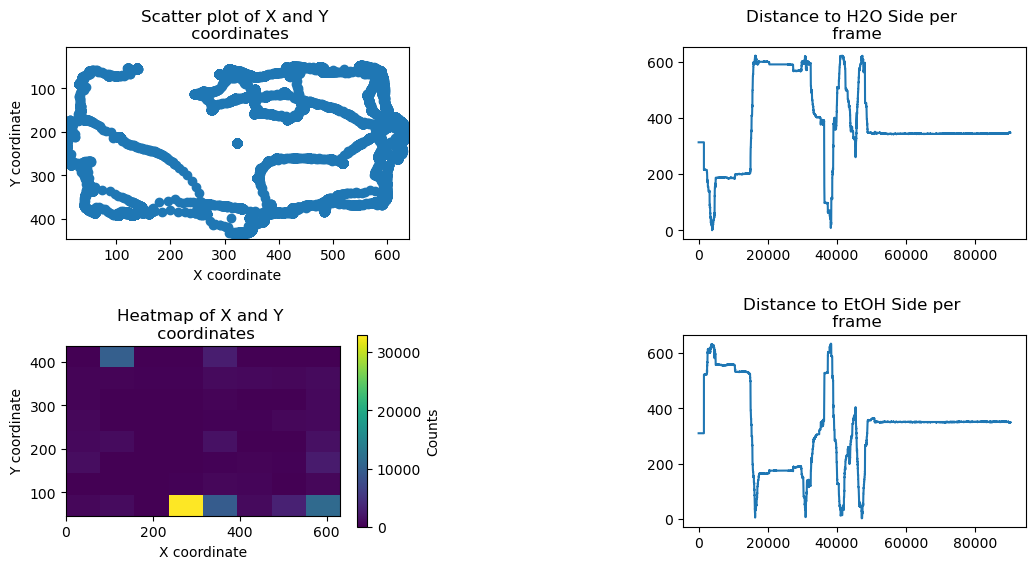

In [44]:
fig, axs = plt.subplots(2,2, figsize=(12,6))
axs[0,0].scatter(x, y)
axs[0,0].set_xlim(roi[0], roi[0] + roi[2])
axs[0,0].set_ylim(roi[1] + roi[3], roi[1])  # Inverting y axis
axs[0,0].set_xlabel('X coordinate')
axs[0,0].set_ylabel('Y coordinate')
axs[0,0].set_title('Scatter plot of X and Y \n coordinates')

# Heatmap in the second subplot
h = axs[1,0].hist2d(x, y, bins=8, cmap='viridis')
cb = fig.colorbar(h[3], ax=axs[1,0])
cb.set_label('Counts')
axs[1,0].set_aspect('equal', adjustable='box')
axs[1,0].set_xlabel('X coordinate')
axs[1,0].set_ylabel('Y coordinate')
axs[1,0].set_title('Heatmap of X and Y \n coordinates')
# axs[1].set_xlim(roi[0], roi[0] + roi[2])
# axs[1].set_ylim(roi[1], roi[1] + roi[3])
# axs[1].set_aspect('equal', adjustable='box')
axs[0,1].plot(h2o)
axs[0,1].set_title("Distance to H2O Side per \n frame")
axs[1,1].plot(etoh)
axs[1,1].set_title("Distance to EtOH Side per \n frame")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.8, hspace=0.5)
plt.show()

In [ ]:
%%timeit -n 1
# Get background that we'll use to subtract from every frame
# although this should maybe be a static image gathered at the
# start of each day/imaging session?
posList = []
disth2o = []
distetoh = []
thresh = 20
area = [1, 100]
video = cv2.VideoCapture(filename)
previous_location = None
if not video.isOpened():
    print("Could not load video! Is the video broken or path correct?")
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
# Get the width and height of the frames
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video file
output_filename = 'combined_video_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
# out = cv2.VideoWriter(output_filename, fourcc, 100, (width * 3, height * 3))

while (video.isOpened()):
    # Capture frame-by-frame
    ret, frame = video.read()
    if not ret:
        cX = roi[0] + roi[2] // 2
        cY = roi[1] + roi[3] // 2
        dist_etoh = 0
        dist_h2o = 0
    else:
        frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
        cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
        subtracted = cv2.subtract(bkgrnd, cropped)
        blurred = cv2.GaussianBlur(subtracted, (3,3), 0)
        r, thresholded = cv2.threshold(blurred, 20, 255, 0)
        inverted = cv2.bitwise_not(thresholded)
        median = cv2.medianBlur(thresholded, 7)
        contours, hierarchy = cv2.findContours(
            median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        filtered_contours_and_areas = [
        (contour, cv2.contourArea(contour))for contour in contours if cv2.contourArea(contour) > 20]
        if filtered_contours_and_areas:
            filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
            contour = filtered_contours[0]
            moments = cv2.moments(contour)
            cX = round(int(moments["m10"] / moments["m00"]), 2)
            cY = round(int(moments["m01"] / moments["m00"]), 2)
            previous_location_x, previous_location_y = cX, cY
        else:
            print("FISH NOT FOUND!")
            print("Interpolating...")
            if previous_location_x is not None and previous_location_y is not None:
                cX = previous_location_x
                cY = previous_location_y
            else:
                # Default to the center of the ROI if no previous location is known
                cX = roi[0] + roi[2] // 2
                cY = roi[1] + roi[3] // 2
    dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
    dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
    disth2o.append(dist_h2o)
    distetoh.append(dist_etoh)
    # img_rgb = cv2.cvtColor(reinvert, cv2.COLOR_GRAY2BGR)
    # cv2.drawContours(img_rgb, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
    # img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
    
    # # Add text to each sub-image
    # cropped_with_text = add_text_to_image(cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR), "Cropped", (10, 20))
    # subtracted_with_text = add_text_to_image(cv2.cvtColor(subtracted, cv2.COLOR_GRAY2BGR), "Subtracted", (10, 20))
    # blurred_with_text = add_text_to_image(cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR), "Blurred", (10, 20))
    # inverted_with_text = add_text_to_image(cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR), "Inverted", (10, 20))
    # thresholded_with_text = add_text_to_image(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGR), "Thresholded", (10, 20))
    # img_rgb_with_text = add_text_to_image(img_rgb, "Final", (10, 20))
    
    # frames = [
    #     cropped_with_text,
    #     subtracted_with_text,
    #     blurred_with_text,
    #     inverted_with_text,
    #     thresholded_with_text,
    #     img_rgb_with_text
    # ]

    # combined_frame = combine_images(frames, cols=3, rows=3)
    # cv2.imshow('Combined Frame', combined_frame)
    # out.write(combined_frame)
    posList.append([cX, cY])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
# out.release()
cv2.destroyAllWindows()
p = np.array(posList, dtype=int)
d_h2o = np.array(disth2o)
d_etoh = np.array(distetoh)
np.savetxt(txtfile,posList, fmt='%d', delimiter=',')
np.savetxt(dh2o, d_h2o)
np.savetxt(detoh, d_etoh)
x = p[:,0]
y = p[:,1]

fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].scatter(x, y)
axs[0].set_xlim(roi[0], roi[0] + roi[2])
axs[0].set_ylim(roi[1] + roi[3], roi[1])  # Inverting y axis
axs[0].set_xlabel('X coordinate')
axs[0].set_ylabel('Y coordinate')
axs[0].set_title('Scatter plot of X and Y \n coordinates')

# Heatmap in the second subplot
h = axs[1].hist2d(x, y, bins=50, cmap='viridis')
cb = fig.colorbar(h[3], ax=axs[1])
cb.set_label('Counts')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('X coordinate')
axs[1].set_ylabel('Y coordinate')
axs[1].set_title('Heatmap of X and Y \n coordinates')
# axs[1].set_xlim(roi[0], roi[0] + roi[2])
# axs[1].set_ylim(roi[1], roi[1] + roi[3])
# axs[1].set_aspect('equal', adjustable='box')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.8, hspace=0.5)
plt.show()


FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT FOUND!
Interpolating...
FISH NOT F

In [ ]:
im = cv2.subtract(bkgrnd, cropped)
im = cv2.GaussianBlur(im, (3,3), 0)
# Threshold arguments: image/array, value for threshold (anything below 0, above kept),
# value to change to
r, i = cv2.threshold(im, 40, 255, 0)
# v.threshold(	src, thresh, maxval, type[, dst]	)
m = cv2.medianBlur(i, 7)
n = cv2.bitwise_not(m)
contours, hierarchy = cv2.findContours(i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours_and_areas = [
    (contour, cv2.contourArea(contour))for contour in contours if cv2.contourArea(contour) > 20]
filtered_contours = [contour for contour, area in filtered_contours_and_areas]
contour = filtered_contours[0]
# Convert the list of contours into a NumPy array
filtered_contours_array = np.array(filtered_contours, dtype=object)
  # -1 means draw all contours, (0, 255, 0) is the color (green), and 3 is the thickness
# Convert the image from BGR to RGB (for proper display with matplotlib)
moments = cv2.moments(filtered_contours[0])
cX = int(moments["m10"] / moments["m00"])
cY = int(moments["m01"] / moments["m00"])
mu11 = moments['mu11']
mu20 = moments['mu20']
mu02 = moments['mu02']
angle = (0.5 * np.arctan2(2 * mu11, mu20 - mu02))
angle_degrees = np.degrees(angle)
img_rgb = cv2.cvtColor(m, cv2.COLOR_GRAY2BGR)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
cv2.drawContours(img_rgb, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[0], radius=15, color=(255,200,0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[1], radius=15, color=(0,0,255), thickness=-1)
# Calculate the end point of the line
line_length = 30
x1 = int(cX + line_length * np.cos(angle))
y1 = int(cY + line_length * np.sin(angle))
x2 = int(cX - line_length * np.cos(angle))
y2 = int(cY - line_length * np.sin(angle))

dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
dist_h20 = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
# use line of orientation for vector
line_vector = np.array([x2, y2]) - np.array([x1, y1])
point_vector = np.array(points[0]) - np.array([x2, y2])
dot_product = np.dot(line_vector, point_vector)
line_vector_magnitude = np.linalg.norm(line_vector)
point_vector_magnitude = np.linalg.norm(point_vector)

# Calculate the angle in radians
angle_radians = np.arccos(dot_product / (line_vector_magnitude * point_vector_magnitude))

# Convert the angle to degrees
angle_degrees = np.degrees(angle_radians)
print(angle_degrees)
# use line of orientation for vector
line_vector2 = np.array([x2, y2]) - np.array([x1, y1])
point_vector2 = np.array(points[1]) - np.array([x2, y2])
dot_product2 = np.dot(line_vector2, point_vector2)
line_vector_magnitude2 = np.linalg.norm(line_vector2)
point_vector_magnitude2 = np.linalg.norm(point_vector2)

# Calculate the angle in radians
angle_radians2 = np.arccos(dot_product2 / (line_vector_magnitude2 * point_vector_magnitude2))

# Convert the angle to degrees
angle_degrees2 = np.degrees(angle_radians2)

cv2.arrowedLine(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
cv2.line(img_rgb, (x2, y2), points[0], (255, 200, 0), thickness=2)
cv2.line(img_rgb, (x2, y2), points[1], (0, 0, 255), thickness=2)
fig2, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0,0].imshow(cropped, cmap='gray')
axs[0,0].set_title('blurred')
axs[0,1].imshow(i, cmap='gray')
axs[0,1].set_title('first threshold')
axs[1,0].imshow(m, cmap='gray')
axs[1,0].set_title('median blur')
axs[1,1].imshow(n, cmap='gray')
axs[1,1].set_title('bitwise not')
axs[2,0].imshow(img_rgb)
axs[2,0].set_title('contours')

In [26]:
def data_producer(video, data_queue, stop_event, roi, bkgrnd, points, previous_location):
    frame_count = 0
    while not stop_event.is_set() and video.isOpened():
        # Capture frame-by-frame
        ret, frame = video.read()
        if not ret:
            print(f"Failed to read frame at count {frame_count}")
            break
        
        frame_count += 1
        print(f"Processing frame {frame_count}")

        frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2GRAY)
        cropped = frame[roi[1]:roi[1] + roi[3], roi[0]:roi[0] + roi[2]]
        
        # Ensure bkgrnd is a numpy array
        if not isinstance(bkgrnd, np.ndarray):
            raise ValueError("Background frame (bkgrnd) is not a numpy array.")
        # Ensure shapes match
        if cropped.shape != bkgrnd.shape:
            raise ValueError(f"Cropped frame shape {cropped.shape} does not match background frame shape {bkgrnd.shape}.")
        
        subtracted = cv2.subtract(bkgrnd, cropped)
        blurred = cv2.GaussianBlur(subtracted, (3, 3), 0)
        r, thresholded = cv2.threshold(blurred, 20, 255, 0)
        inverted = cv2.bitwise_not(thresholded)
        median = cv2.medianBlur(thresholded, 7)
        contours, hierarchy = cv2.findContours(
            median, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        filtered_contours_and_areas = [
            (contour, cv2.contourArea(contour)) for contour in contours if cv2.contourArea(contour) > 20
        ]
        if filtered_contours_and_areas:
            filtered_contours = [contour for contour, area in [max(filtered_contours_and_areas, key=lambda x: x[1])]]
            contour = filtered_contours[0]
            moments = cv2.moments(contour)
            cX = round(int(moments["m10"] / moments["m00"]), 2)
            cY = round(int(moments["m01"] / moments["m00"]), 2)
            previous_location[0], previous_location[1] = cX, cY
        else:
            print("FISH NOT FOUND!")
            print("Interpolating...")
            if previous_location[0] is not None and previous_location[1] is not None:
                cX = previous_location[0]
                cY = previous_location[1]
            else:
                cX = roi[0] + roi[2] // 2
                cY = roi[1] + roi[3] // 2

        dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
        dist_h2o = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))

        data_queue.put((cX, cY, dist_etoh, dist_h2o))

def data_consumer(data_queue, stop_event, file_path):
    with h5py.File(file_path, 'w') as h5f:
        dset_center = h5f.create_dataset('center', (0, 2), maxshape=(None, 2), dtype='f')
        dset_dist_etoh = h5f.create_dataset('dist_etoh', (0,), maxshape=(None,), dtype='f')
        dset_dist_h2o = h5f.create_dataset('dist_h2o', (0,), maxshape=(None,), dtype='f')
        
        # Add ROI and points as attributes
        h5f.attrs['roi'] = roi
        h5f.attrs['points'] = np.array(points).flatten()

        while not stop_event.is_set() or not data_queue.empty():
            try:
                cX, cY, dist_etoh, dist_h2o = data_queue.get(timeout=1)

                # Resize datasets to accommodate new data
                dset_center.resize(dset_center.shape[0] + 1, axis=0)
                dset_dist_etoh.resize(dset_dist_etoh.shape[0] + 1, axis=0)
                dset_dist_h2o.resize(dset_dist_h2o.shape[0] + 1, axis=0)

                # Append new data
                dset_center[-1] = [cX, cY]
                dset_dist_etoh[-1] = dist_etoh
                dset_dist_h2o[-1] = dist_h2o

                data_queue.task_done()
            except queue.Empty:
                continue

# Your configuration here
video = cv2.VideoCapture("output_video.mp4")
if not video.isOpened():
    raise ValueError("Failed to open the video file.")

roi = roi  # Define your ROI
bkgrnd = bkgrnd 
if bkgrnd is None:
    raise ValueError("Failed to load the background image.")
points = points  # Define your points
previous_location = [None, None]

data_queue = queue.Queue(maxsize=100)
stop_event = threading.Event()

file_path = filename +"_output.h5"

producer_thread = threading.Thread(target=data_producer, args=(video, data_queue, stop_event, roi, bkgrnd, points, previous_location))
consumer_thread = threading.Thread(target=data_consumer, args=(data_queue, stop_event, file_path))

producer_thread.start()
consumer_thread.start()

try:
    producer_thread.join()
except KeyboardInterrupt:
    print("Stopping...")
finally:
    stop_event.set()
    producer_thread.join()
    consumer_thread.join()
    video.release()
    print("Data processing completed.")


Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Processing frame 48
Processing frame 49
Processing frame 50
Processin

156.7014729563382


Text(0.5, 1.0, 'contours')

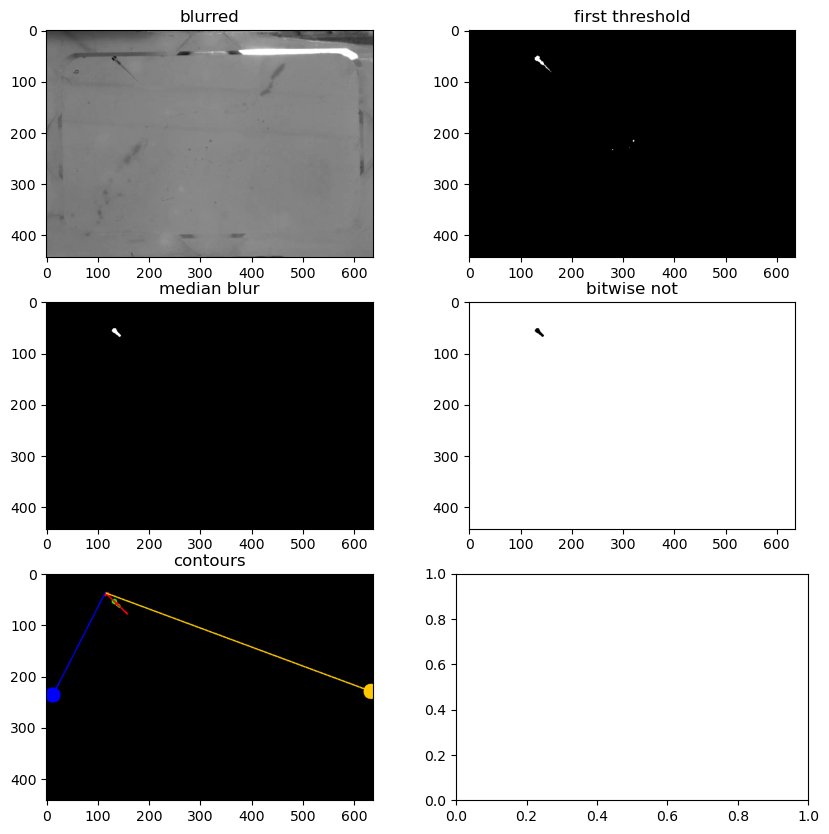

In [11]:
im = cv2.subtract(bkgrnd, cropped)
im = cv2.GaussianBlur(im, (3,3), 0)
# Threshold arguments: image/array, value for threshold (anything below 0, above kept),
# value to change to
r, i = cv2.threshold(im, 20, 255, 0)
# v.threshold(	src, thresh, maxval, type[, dst]	)
m = cv2.medianBlur(i, 7)
n = cv2.bitwise_not(m)
contours, hierarchy = cv2.findContours(i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours_and_areas = [
    (contour, cv2.contourArea(contour))for contour in contours if cv2.contourArea(contour) > 20]
filtered_contours = [contour for contour, area in filtered_contours_and_areas]
contour = filtered_contours[0]
# Convert the list of contours into a NumPy array
filtered_contours_array = np.array(filtered_contours, dtype=object)
  # -1 means draw all contours, (0, 255, 0) is the color (green), and 3 is the thickness
# Convert the image from BGR to RGB (for proper display with matplotlib)
moments = cv2.moments(filtered_contours[0])
cX = int(moments["m10"] / moments["m00"])
cY = int(moments["m01"] / moments["m00"])
mu11 = moments['mu11']
mu20 = moments['mu20']
mu02 = moments['mu02']
angle = (0.5 * np.arctan2(2 * mu11, mu20 - mu02))
angle_degrees = np.degrees(angle)
img_rgb = cv2.cvtColor(m, cv2.COLOR_GRAY2BGR)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
cv2.drawContours(img_rgb, filtered_contours, -1, (0, 255, 0), thickness=cv2.FILLED)
img_rgb = cv2.circle(img_rgb, (cX,cY), radius=3, color=(255, 0, 0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[0], radius=15, color=(255,200,0), thickness=-1)
img_rgb = cv2.circle(img_rgb, points[1], radius=15, color=(0,0,255), thickness=-1)
# Calculate the end point of the line
line_length = 30
x1 = int(cX + line_length * np.cos(angle))
y1 = int(cY + line_length * np.sin(angle))
x2 = int(cX - line_length * np.cos(angle))
y2 = int(cY - line_length * np.sin(angle))

dist_etoh = np.linalg.norm(np.array(points[0]) - np.array([cX, cY]))
dist_h20 = np.linalg.norm(np.array(points[1]) - np.array([cX, cY]))
# use line of orientation for vector
line_vector = np.array([x2, y2]) - np.array([x1, y1])
point_vector = np.array(points[0]) - np.array([x2, y2])
dot_product = np.dot(line_vector, point_vector)
line_vector_magnitude = np.linalg.norm(line_vector)
point_vector_magnitude = np.linalg.norm(point_vector)

# Calculate the angle in radians
angle_radians = np.arccos(dot_product / (line_vector_magnitude * point_vector_magnitude))

# Convert the angle to degrees
angle_degrees = np.degrees(angle_radians)
print(angle_degrees)
# use line of orientation for vector
line_vector2 = np.array([x2, y2]) - np.array([x1, y1])
point_vector2 = np.array(points[1]) - np.array([x2, y2])
dot_product2 = np.dot(line_vector2, point_vector2)
line_vector_magnitude2 = np.linalg.norm(line_vector2)
point_vector_magnitude2 = np.linalg.norm(point_vector2)

# Calculate the angle in radians
angle_radians2 = np.arccos(dot_product2 / (line_vector_magnitude2 * point_vector_magnitude2))

# Convert the angle to degrees
angle_degrees2 = np.degrees(angle_radians2)

cv2.arrowedLine(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
cv2.line(img_rgb, (x2, y2), points[0], (255, 200, 0), thickness=2)
cv2.line(img_rgb, (x2, y2), points[1], (0, 0, 255), thickness=2)
fig2, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0,0].imshow(cropped, cmap='gray')
axs[0,0].set_title('blurred')
axs[0,1].imshow(i, cmap='gray')
axs[0,1].set_title('first threshold')
axs[1,0].imshow(m, cmap='gray')
axs[1,0].set_title('median blur')
axs[1,1].imshow(n, cmap='gray')
axs[1,1].set_title('bitwise not')
axs[2,0].imshow(img_rgb)
axs[2,0].set_title('contours')

In [15]:
import cv2
import os

def create_video_clip(input_video_path, output_video_path, start_time, end_time):
    # Verify the input file exists
    if not os.path.isfile(input_video_path):
        print(f"Error: The file {input_video_path} does not exist.")
        return

    # Open the video file
    cap = cv2.VideoCapture(input_video_path)

    # Check if video file opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return

    # Get frames per second (fps) and frame count
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate start and end frames
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For .mp4 file
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    current_frame = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if start_frame <= current_frame <= end_frame:
            out.write(frame)

        current_frame += 1
        if current_frame > end_frame:
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    print(f"Video clip created successfully: {output_video_path}")

# Example usage
input_video = '/absolute/path/to/your/input_video.mp4'
output_video = 'output_video.mp4'
start_time = 10  # Start time in seconds
end_time = 20    # End time in seconds

create_video_clip(filename, output_video, start_time, end_time)


Video clip created successfully: output_video.mp4


In [12]:
filename

'/home/jmdelahanty/Desktop/20240617_fish1.avi'

In [44]:
plt.close('all')

In [ ]:
class Cropper:
    def __init__(self, video_path):
        self.video_path = video_path
        self.roi = None

    def select_roi(self):
        cap = cv2.VideoCapture(self.video_path)
        ret, frame = cap.read()
        if not ret:
            print("Failed to read video")
            cap.release()
            return
        
        # Select ROI
        self.roi = cv2.selectROI("Select ROI", frame, fromCenter=False, showCrosshair=True)
        cv2.destroyAllWindows()
        cap.release()

    def crop_and_save(self, output_path):
        if self.roi is None:
            print("ROI not set. Use select_roi() first.")
            return

        cap = cv2.VideoCapture(self.video_path)
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(self.roi[2]), int(self.roi[3])))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Crop the frame
            x, y, w, h = self.roi
            cropped_frame = frame[y:y+h, x:x+w]

        cap.release()
        print(f"Cropped video saved to {output_path}")

cropper = Cropper(video_path)
cropper.select_roi()  # Manually select the ROI from the first frame
cropper.crop_and_save(output_path)
